In [ ]:
!!pip install -q MOABB

In [ ]:
!pip install pywd

In [3]:
import numpy as np
import scipy.signal
import scipy.io as sio
import matplotlib
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import mne
from pywt import wavedec 

In [4]:
import moabb
from moabb.datasets import EPFLP300, utils
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import LeftRightImagery
from moabb.pipelines.features import LogVariance
from mne.filter import construct_iir_filter
moabb.set_log_level("info")


In [5]:
dataset=EPFLP300()

In [7]:
def getData(subjectNumbers,dataset=EPFLP300()):
  return dataset.get_data(subjectNumbers)

In [6]:
def getSubjectData(subjectNumber,session_number,run_number):
  session = f'session_{session_number}'
  run = f'run_{run_number}'
  return getData([subjectNumber])[subjectNumber][session][run]

**Necessary Information**:


*   We have data of 8 subjects. (from 1 to 9, 5 is excluded).
*   Each subject has data of 4 recording sessions.
*   Each session has 6 runs.
*   Each run is a recording of raw EEG signals in a duration of ~ 60 s.






In [28]:
data= getSubjectData(1,1,1)

Since we are dealing with MNE library, it prodives the data in form of **RawArray**.

The dimension of the RawArray is (num_Channels x num_Samples).

In [10]:
data.get_data

<bound method get_data of <RawArray | 35 x 114687 (56.0 s), ~30.7 MB, data loaded>>

**Necessary Information about the structure of a single run**:

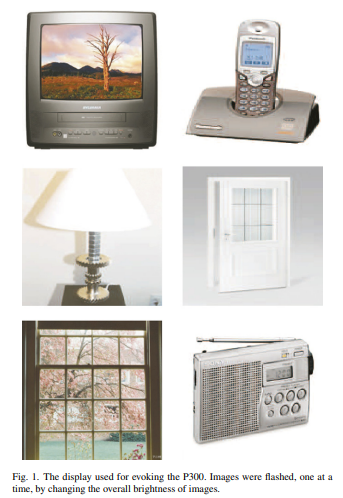

*   We essentially have 6 runs inside a session because we have 6 images in our paradigm. So each run is essentially dedicated for one image.
*   For a single run, the subject is asked to focus on one image.
*   For a single run, the images on the grid were flashed in random sequence. The sequence of flashes was block-randomized, this means that after six flashes each image was flashed once, after twelve flashes each image was flashed twice, etc. 
*   The number of blocks was chosen randomly between 20 and 25. On average 22.5 (23) blocks of six flashes were displayed in one run.
*   knowing that the subject only focuses on one image in a single run, and we have ~23 block of flashes, thus we have 23 target signals and 23x5 = 115 non-target signals inside single run.
*   Each flash of an images lasts for 400 ms, The images only flash in the first 100 ms, and remains not flashed for the remaining 300 ms.
*   knowing that we have ~23 block of flashes in a single run, where each block consists of 6 flashes (one for each image), so we have 23x6 = 138 flashes inside the run. and knowing that each flash has a duration of 400 ms, so the run lasts for 138x0.4 = 55.2 seconds.



Count of Stimulus in samples (i.e. count of target segments & non-target).

Target has value of 2 and Non-Target hase value of 1 in STI column of the dataset. 

**Note**: the rest of EEG recording in the dataframe has values of 0, meaning that it's neither target nor non-target.

In [29]:
df=data.to_data_frame()
df.STI.value_counts()

0.0    114549
1.0       115
2.0        23
Name: STI, dtype: int64

to Get index of First flash (Stimulus)

In [30]:
df.STI.ne(0).idxmax()

819

In [31]:
df.iloc[819]

time        0.399902
Fp1      3578.843750
AF3     27160.750000
F7      -9499.781250
F3      19571.750000
FC1      1656.812500
FC5     -1478.093750
T7      -8032.781250
C3       3472.593750
CP1    -12703.375000
CP5    -11995.437500
P7       2006.437500
P3      -7322.250000
Pz      11253.906250
PO3     -2716.781250
O1        223.062500
Oz       -989.312500
O2       2215.562500
PO4     -6220.125000
P4      -6175.562500
P8      -5917.625000
CP6     -3828.718750
CP2     -4155.562500
C4       7376.375000
T8       8960.312500
FC6     -4080.625000
FC2      7104.343750
F4      -2386.750000
F8     -16126.531250
AF4      4861.500000
Fp2     22986.468750
Fz       6994.093750
Cz       8327.312500
MA1         0.006691
MA2        -0.006691
STI         1.000000
Name: 819, dtype: float64

Get Sample indicies of Target stimulus (flash)

In [13]:
Target = df[df['STI']==2].index.values
val = np.full(len(Target),2)
target = pd.DataFrame(Target)
target["value"]=val
target

,0,value
0,4099,2
1,5740,2
2,11482,2
3,16406,2
4,21327,2
5,26251,2
6,34453,2
7,36915,2
8,40197,2
9,48400,2


Get Sample indicies of Non-Target stimulus (flash)

In [14]:
nonTarget = df[df['STI']==1].index.values
value = np.full(len(nonTarget),1)
nontarget= pd.DataFrame(nonTarget)
nontarget["value"]=value
nontarget

,0,value
0,819,1
1,1636,1
2,2459,1
3,3280,1
4,4921,1
...,...,...
110,109109,1
111,109950,1
112,110749,1
113,112389,1


Combine both target and non-target dataframes and sort (based on time) target and non-target samples.

In [15]:
df2 = nontarget.append(target,ignore_index=True) 
TargetNnonTarget = df2.sort_values(by=[0],ignore_index=True)
TargetNnonTarget

,0,value
0,819,1
1,1636,1
2,2459,1
3,3280,1
4,4099,2
...,...,...
133,109950,1
134,110749,1
135,111570,2
136,112389,1


**Displaying single Segment**

In [16]:
segment = df.iloc[1636:2459]

In [17]:
segment

,time,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,...,FC2,F4,F8,AF4,Fp2,Fz,Cz,MA1,MA2,STI
1636,0.798828,3573.531250,27158.343750,-9506.718750,19563.343750,1644.125000,-1503.750000,-8060.906250,3459.937500,-12713.687500,...,7116.718750,-2384.250000,-16164.562500,4868.843750,22989.937500,6994.781250,8338.062500,0.006682,-0.006682,1.0
1637,0.799316,3569.250000,27154.000000,-9510.000000,19558.812500,1639.375000,-1501.250000,-8066.312500,3455.500000,-12720.437500,...,7110.687500,-2389.531250,-16169.531250,4863.375000,22985.406250,6989.718750,8332.093750,0.006677,-0.006677,0.0
1638,0.799805,3565.671875,27150.171875,-9515.328125,19558.015625,1638.984375,-1499.109375,-8070.140625,3455.890625,-12721.515625,...,7108.390625,-2392.890625,-16170.265625,4860.671875,22984.109375,6987.671875,8328.109375,0.006681,-0.006681,0.0
1639,0.800293,3567.187500,27151.562500,-9517.968750,19559.468750,1641.343750,-1496.718750,-8070.343750,3457.625000,-12717.156250,...,7110.000000,-2390.375000,-16166.375000,4864.093750,22984.812500,6988.031250,8331.750000,0.006689,-0.006689,0.0
1640,0.800781,3570.468750,27155.875000,-9516.812500,19565.281250,1646.718750,-1490.531250,-8067.218750,3463.906250,-12711.093750,...,7115.187500,-2386.250000,-16160.812500,4870.500000,22988.218750,6993.375000,8338.875000,0.006696,-0.006696,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2454,1.198242,3574.781250,27167.218750,-9540.468750,19575.000000,1640.218750,-1477.062500,-8059.250000,3461.218750,-12723.187500,...,7094.656250,-2404.718750,-16181.125000,4848.687500,22977.218750,6974.687500,8320.843750,0.006689,-0.006689,0.0
2455,1.198730,3577.031250,27165.968750,-9519.718750,19572.062500,1634.718750,-1499.125000,-8055.187500,3457.781250,-12725.062500,...,7093.093750,-2406.156250,-16184.343750,4846.843750,22975.250000,6970.531250,8316.562500,0.006685,-0.006685,0.0
2456,1.199219,3576.343750,27163.093750,-9498.125000,19569.406250,1628.562500,-1509.312500,-8051.343750,3452.250000,-12731.000000,...,7088.406250,-2411.906250,-16187.812500,4842.156250,22971.218750,6964.750000,8311.562500,0.006683,-0.006683,0.0
2457,1.199707,3572.640625,27163.765625,-9479.578125,19568.453125,1623.421875,-1506.046875,-8046.453125,3448.796875,-12732.078125,...,7085.796875,-2414.078125,-16188.234375,4841.546875,22971.203125,6962.734375,8309.609375,0.006681,-0.006681,0.0


**Cropping Segment out of RawArray & plotting it.**

In [18]:
d = data.copy()
segment.reset_index(inplace=True)
tmax= segment['time'][len(segment)-1]
tmin= segment['time'][0]

In [19]:
seg=d.crop(tmin=tmin, tmax=tmax)

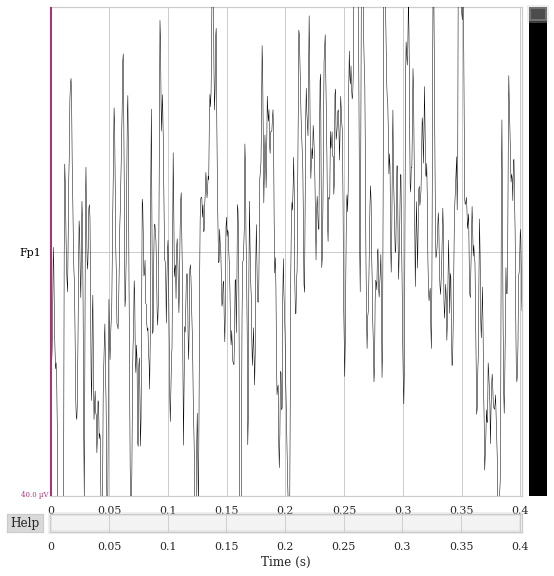

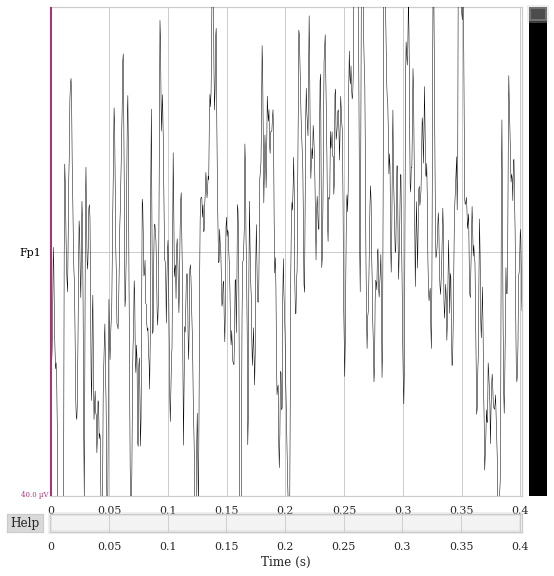

In [20]:
seg.plot(n_channels=1)

Applying Preprocessing steps on a segment and plot it. Ths steps are:


*   Filtering, bandpass butterworth filter (1-12 hz). 
*   Resampling to 32hz.
*   Scaling to (-1,1).



In [14]:
def filterAndResampleData(data,lp=12,hp=1,sf=2048,resample=32):
  iir_params = dict(order=4, ftype='butter', output='sos')  
  iir_params = construct_iir_filter(iir_params, [hp,lp], None, sf, 'bandpass', return_copy=False)
  data.filter(method='iir',iir_params=iir_params,h_freq=hp,l_freq=lp)
  return data.resample(32)

In [22]:
filtered = filterAndResampleData(seg)

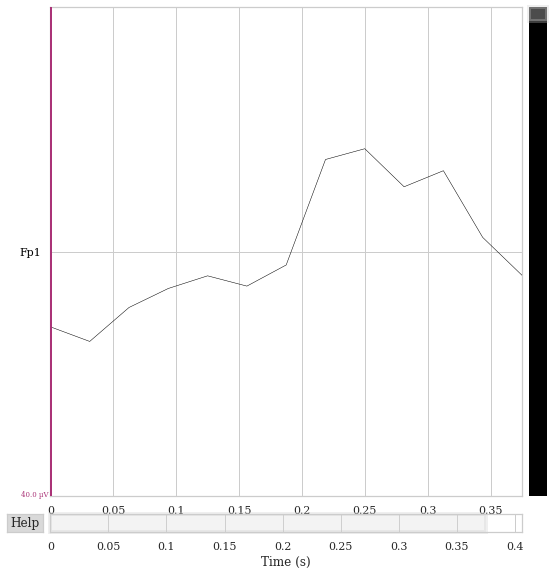

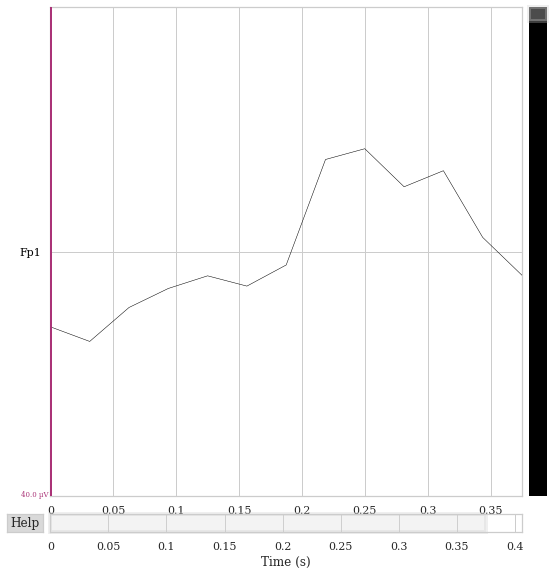

In [23]:
filtered.plot(n_channels=1)

In [24]:
filtered.to_data_frame()

,time,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,...,FC2,F4,F8,AF4,Fp2,Fz,Cz,MA1,MA2,STI
0,0.00000,-4.979474,-1.499772,-6.145104,1.731395,-4.059722,16.096570,0.510655,2.057869,-1.382184,...,-10.855303,-8.588769,-1.989257,-7.954798,-6.313489,-7.116435,-7.887349,0.006686,-0.006686,1.0
1,0.03125,-6.173343,-2.004380,-16.543883,3.079163,-5.905811,25.986546,3.509738,3.957723,2.636245,...,-17.400808,-9.675249,-0.129602,-12.094695,-9.868627,-9.681731,-9.083793,0.006689,-0.006689,0.0
2,0.06250,-3.400402,-0.138652,-12.340964,1.183270,-7.199617,13.118211,6.975830,0.903364,9.180211,...,-8.603329,-0.751535,6.174611,-8.585146,-7.615216,-4.737763,-2.143619,0.006693,-0.006693,0.0
3,0.09375,-1.846337,0.507708,-9.705016,-0.343606,-5.698464,14.695098,4.630859,-0.535376,8.580977,...,-2.296057,2.370811,6.967223,-3.935788,-2.113452,-3.771452,-2.981902,0.006691,-0.006691,0.0
4,0.12500,-0.813097,0.729402,-2.734252,1.100243,-2.925873,14.731321,0.905702,-1.086936,-3.372081,...,-6.153679,-3.549430,-3.750852,-4.866055,-1.386462,-5.559888,-6.642151,0.006696,-0.006696,0.0
5,0.15625,-1.653113,-1.959858,-4.195778,0.536287,2.638776,13.012000,-1.864673,1.977472,-9.048585,...,-4.220898,-3.402463,1.529740,-1.068098,0.569272,-2.378170,-4.142826,0.006688,-0.006688,0.0
6,0.18750,0.073759,0.368602,-12.497098,4.376529,12.290141,19.729240,-2.620779,7.801609,-2.610146,...,5.692020,3.186123,6.522997,5.635192,5.286572,4.537015,5.574950,0.006694,-0.006694,0.0
7,0.21875,8.691378,6.944444,-6.956568,10.276251,14.685716,15.476177,-0.236486,7.362836,-3.225090,...,8.021575,9.106080,1.931108,11.387693,8.206558,8.852843,6.394067,0.006695,-0.006695,0.0
8,0.25000,9.571309,3.800022,-15.465583,6.356336,10.487865,12.994823,-3.392088,4.373503,0.677344,...,0.209334,6.641140,6.503522,12.350648,5.505521,4.812276,0.199737,0.006694,-0.006694,0.0
9,0.28125,6.462278,0.078930,-25.348643,2.356422,12.250336,12.853853,-2.920448,7.588216,11.265428,...,3.194483,4.570983,4.149393,11.007572,5.067871,6.100630,9.417201,0.006693,-0.006693,0.0


We extract **one feature vector** out of each single segment inside a run.
So we end up with pairs of (feature vectors, label). Label is either target or non-target.

In [25]:
def scaleAndExtractFeatures(segment):
  scaler = MinMaxScaler(feature_range = (-1,1))
  df = segment.to_data_frame()
  columns = ['time', 'MA1', 'MA2' , 'STI']
  df.drop(columns,axis=1,inplace=True)
  featureVector = []
  for val in df.columns.values:
    vals=df[val].values.reshape(-1, 1)
    scaled = scaler.fit_transform(vals)
    col= scaled.reshape(13,)
    cA2, cD2, cD1 = wavedec(col,'db1',level=2)
    featureVector.extend(cD2)
    featureVector.extend(cD1)
  return featureVector

In [26]:
def divideSingleRun(df, data):
  TargetNnonTarget= getTottalData(df)
  segments=[]
  output=[]
  length=len(TargetNnonTarget)
  for index, row in TargetNnonTarget.iterrows():
    if(index==length-1):
      Segment = df.iloc[TargetNnonTarget[0].iloc[index]:TargetNnonTarget[0].iloc[index]+820]
    else:
      Segment = df.iloc[TargetNnonTarget[0].iloc[index]:TargetNnonTarget[0].iloc[index+1]]

    # crop segment from RawArray
    d = data.copy()
    Segment.reset_index(inplace=True)
    tmax= Segment['time'][len(Segment)-1]
    tmin= Segment['time'][0]
    seg=d.crop(tmin=tmin, tmax=tmax)

    # Filter and resample
    filtered = filterAndResampleData(seg)

    # Scale and extract features
    # featureVector= scaleAndExtractFeatures(filtered,index)

    segments.append(filtered)
    output.append(TargetNnonTarget['value'].iloc[index])
  return segments, output

In [56]:
segments, target = divideSingleRun(df, data)

In [35]:
TargetNnonTarget= getTottalData(df)
segments=[]
output=[]
length=len(TargetNnonTarget)
for index, row in TargetNnonTarget.iterrows():
  if(index==length-1):
    Segment = df.iloc[TargetNnonTarget[0].iloc[index]:TargetNnonTarget[0].iloc[index]+820]
  else:
    Segment = df.iloc[TargetNnonTarget[0].iloc[index]:TargetNnonTarget[0].iloc[index+1]]

  segments.append(Segment)

  # d = data.copy()
  # Segment.reset_index(inplace=True)
  # tmax= Segment['time'][len(Segment)-1]
  # tmin= Segment['time'][0]
  # seg=d.crop(tmin=tmin, tmax=tmax)

In [45]:
# for seg in segments:
#   print(len(seg))
len(segments[67])

758

In [46]:
Segment = segments[67]
d = data.copy()
Segment.reset_index(inplace=True)
tmax= Segment['time'][len(Segment)-1]
tmin= Segment['time'][0]
seg=d.crop(tmin=tmin, tmax=tmax)
seg.resample(86)
seg

<RawArray | 35 x 32 (0.4 s), ~60 kB, data loaded>

In [47]:
seg.to_data_frame()

,time,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,...,FC2,F4,F8,AF4,Fp2,Fz,Cz,MA1,MA2,STI
0,0.000000,3563.660015,27364.712311,-9757.651791,19740.544125,1577.208560,-917.706906,-8163.498567,3373.023585,-12810.669581,...,6945.612224,-2823.010339,-16390.938884,4632.342779,23066.629585,6489.476733,8296.234546,0.006621,-0.006621,1.0
1,0.011628,3560.296762,27358.884335,-9763.282180,19730.177786,1567.537261,-928.590434,-8164.340633,3365.296656,-12813.251360,...,6942.730606,-2824.743580,-16392.912097,4630.474487,23062.013535,6482.248308,8292.262320,0.006627,-0.006627,0.0
2,0.023256,3547.076878,27346.649235,-9766.870235,19718.023426,1557.944119,-927.617725,-8172.229095,3357.087854,-12824.553997,...,6927.184338,-2840.016162,-16405.140426,4613.306779,23050.338540,6468.201437,8277.924567,0.006625,-0.006625,0.0
3,0.034884,3541.588753,27342.464250,-9768.288463,19710.711927,1546.037357,-941.876514,-8175.321161,3345.577550,-12836.720268,...,6914.083074,-2852.786415,-16405.025545,4604.141592,23036.161585,6458.475742,8264.159223,0.006619,-0.006619,0.0
4,0.046512,3547.384547,27351.425440,-9770.386381,19724.982761,1549.980120,-915.243571,-8168.299355,3356.466124,-12828.211372,...,6912.130242,-2856.381469,-16407.231836,4599.042406,23040.527385,6461.843978,8263.124672,0.006623,-0.006623,0.0
5,0.058140,3546.502148,27348.230630,-9766.468998,19723.502580,1558.886415,-926.973103,-8167.072748,3361.412539,-12819.549068,...,6916.986990,-2861.325865,-16420.145622,4594.866975,23038.848355,6465.834679,8270.539186,0.006615,-0.006615,0.0
6,0.069767,3561.590936,27366.385420,-9747.979167,19734.029001,1570.442171,-934.369917,-8157.451667,3368.545175,-12808.364394,...,6938.025633,-2841.470180,-16391.215495,4616.421960,23058.522840,6482.151020,8287.835329,0.006634,-0.006634,0.0
7,0.081395,3545.069204,27349.072859,-9770.522196,19722.938042,1562.094796,-933.455034,-8171.112216,3358.439843,-12817.114140,...,6926.966640,-2847.301107,-16396.069809,4607.933856,23041.526286,6471.155294,8281.684697,0.006629,-0.006629,0.0
8,0.093023,3538.167759,27344.090296,-9785.539139,19713.636302,1554.815220,-946.845323,-8181.983465,3350.620667,-12823.882246,...,6923.479807,-2852.198399,-16391.694092,4604.448018,23041.317092,6461.271760,8274.876700,0.006619,-0.006619,0.0
9,0.104651,3536.841353,27344.150466,-9778.559104,19718.245037,1556.345978,-937.658579,-8172.624485,3357.025716,-12818.369060,...,6923.233730,-2853.475018,-16391.780071,4601.976785,23043.353676,6459.124038,8277.830866,0.006611,-0.006611,0.0


In [19]:
TargetNnonTarget= getTottalData(df)
Segmen = df.iloc[TargetNnonTarget[0].iloc[66]:TargetNnonTarget[0].iloc[66+1]]
d = data.copy()
Segmen.reset_index(inplace=True)
tmax= Segmen['time'][len(Segmen)-1]
tmin= Segmen['time'][0]
seg=d.crop(tmin=tmin, tmax=tmax)

# Filter and resample
filtered = filterAndResampleData(seg)

In [50]:
filtered.to_data_frame()

,time,Fp1,AF3,F7,F3,FC1,FC5,T7,C3,CP1,...,FC2,F4,F8,AF4,Fp2,Fz,Cz,MA1,MA2,STI
0,0.00000,-0.407091,0.563922,1.954578,-0.104734,-0.565582,0.468913,2.416417,1.693617,2.641283,...,-0.332163,-0.590744,-1.056029,0.455719,1.312301,0.943712,1.064426,0.006628,-0.006628,2.0
1,0.03125,9.010606,9.709474,-3.006982,11.562449,10.255003,4.805806,-6.788618,0.952195,1.272773,...,10.579795,12.136248,-4.253772,7.249493,7.950362,9.839315,3.966283,0.006638,-0.006638,0.0
2,0.06250,7.360704,8.619107,-1.383706,10.149644,12.016387,3.947561,-5.596323,0.848054,1.413230,...,5.827168,13.150758,2.804450,8.844807,11.675711,9.963235,1.839450,0.006634,-0.006634,0.0
3,0.09375,-1.885296,-2.394401,-4.455456,-1.984372,-0.683602,-4.234137,-5.794528,-7.200120,-11.431209,...,-3.217692,3.908927,8.801410,-0.798432,2.720184,-2.804367,-10.839541,0.006641,-0.006641,0.0
4,0.12500,-5.918438,-7.634687,-10.649047,-7.681992,-8.558262,-6.835364,-10.018777,-12.370647,-15.964601,...,-4.712271,-2.863607,4.327517,-6.002473,-2.426945,-8.925930,-15.483651,0.006639,-0.006639,0.0
5,0.15625,1.214890,-0.662039,-5.949587,-0.105725,1.970187,-2.450026,-8.689410,-3.989421,-0.949721,...,0.685025,-0.428471,4.911367,-1.059654,1.940815,-0.618783,-1.799680,0.006637,-0.006637,0.0
6,0.18750,9.173982,8.459283,0.143539,9.339449,9.572980,5.509987,-6.078988,1.424634,3.288378,...,7.962846,5.925389,7.109690,4.083039,2.217110,5.338946,6.827898,0.006634,-0.006634,0.0
7,0.21875,7.182241,5.195449,2.544420,5.166182,5.543487,0.454284,-6.916524,-1.393195,-6.803264,...,12.508113,15.759972,6.589343,9.096628,2.224791,3.382084,3.483840,0.006632,-0.006632,0.0
8,0.25000,3.503634,0.511147,-2.962307,0.940401,4.001478,0.860099,-5.697971,-0.822006,-6.928876,...,8.404585,17.115942,4.920173,10.984570,5.062299,1.588614,1.344107,0.006629,-0.006629,0.0
9,0.28125,-1.675661,-4.175036,-4.482868,-2.903538,-1.830018,0.898452,-0.111167,-2.688700,-5.504409,...,-8.153980,-3.651633,-9.512974,-4.500749,-4.152147,-7.815220,-1.805680,0.006630,-0.006630,0.0


In [ ]:
featureVector

In [32]:
def getTargetData(df):
  Target = df[df['STI']==2].index.values
  val = np.full(len(Target),2)
  targetDF= pd.DataFrame(Target)
  targetDF["value"]=val
  return targetDF

In [33]:
def getNonTargetData(df):
  nonTarget = df[df['STI']==1].index.values
  value = np.full(len(nonTarget),1)
  nontargetDF= pd.DataFrame(nonTarget)
  nontargetDF["value"]=value
  return nontargetDF

In [34]:
def getTottalData(df):
  targetDF = getTargetData(df)
  nontargetDF = getNonTargetData(df)
  totaldf = nontargetDF.append(targetDF,ignore_index=True) 
  TargetNnonTarget = totaldf.sort_values(by=[0],ignore_index=True)
  return TargetNnonTarget

In [ ]:
def divideSingleRun(df):
  TargetNnonTarget= getTottalData(df)
  segments=[]
  output=[]
  length=len(TargetNnonTarget)
  for index, row in TargetNnonTarget.iterrows():
    if(index==length-1):
      Segment = df.iloc[TargetNnonTarget[0].iloc[index]:TargetNnonTarget[0].iloc[index]+820]
    else:
      Segment = df.iloc[TargetNnonTarget[0].iloc[index]:TargetNnonTarget[0].iloc[index+1]]
    segments.append(Segment)
    output.append(TargetNnonTarget['value'].iloc[index])
  return segments, output

In [ ]:
events = mne.find_events(data, stim_channel='STI', verbose=True)

In [ ]:
events

In [ ]:
data.plot(events, n_channels=1)